In [1]:
import pickle
import os
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from utils_network import (
    filter_graph_by_attribute,
    count_nodes_by_attribute
)
from utils_globals import *
from utils_nlp import (
    clean_wikipedia_text,
    process_text,
    compute_tf_idf,
    calculate_modularity,
    greedy_modularity_optimization,
    find_unassigned_subfields,
    get_louvain_modularity,
    load_glove_embeddings,
    compute_tf_idf_weighted_embeddings,
    plot_confusion_matrix,
    create_similarity_graph,
    filter_top_n_edges,
    visualize_forceatlas2_graph
)
from fa2_modified import ForceAtlas2


In [2]:
# Uncomment the following lines to download the GloVe embeddings just once

# import requests, zipfile, io

# def download_glove(destination_path="glove.6B.300d.txt"):
#     url = "http://nlp.stanford.edu/data/glove.6B.zip"
#     print("Downloading GloVe embeddings...")
#     response = requests.get(url)
#     with zipfile.ZipFile(io.BytesIO(response.content)) as z:
#         z.extract("glove.6B.300d.txt", path=".")
#     print("GloVe embeddings downloaded and extracted.")

# glove_file = "glove.6B.300d.txt"
# if not os.path.exists(glove_file):
#     download_glove()

# 1. Import Files

In [3]:
glove_file = "glove.6B.300d.txt" 
# Load the graph and related data
S_undirected = pickle.load(open(PICKLE_DIR + "/graph_undirected.pkl", "rb"))
philosopher_subfield_info = pickle.load(open(PICKLE_DIR + "/philosopher_subfield_info.pkl", "rb"))

# Filter the graph by subfields
S_subfields = filter_graph_by_attribute(
    graph=S_undirected,
    attribute_info=philosopher_subfield_info,
    attribute_name='subfields',
    verbose=True
)
print("Subfield graph: ", S_subfields)
print("-"*50)
count_nodes_by_attribute(S_subfields, 'subfields', verbose=True)
print("-"*50)


Did not find subfields for: 768 philosophers (therefore not included in the filtered graph)
 -> Example of removed nodes: ['Johann_Augustus_Eberhard', 'Judah_Leon_Abravanel', 'William_of_Moerbeke']
Original graph: 1362 nodes and 8895 edges
Filtered 'subfields' graph: 594 nodes and 4223 edges
Subfield graph:  Graph with 594 nodes and 4223 edges
--------------------------------------------------
Number of nodes by subfields:
 -> logicians: 89
 -> philosophers of science: 45
 -> ethicists: 115
 -> critical theorists: 41
 -> sociopolitical thinkers: 131
 -> political philosophers: 135
 -> epistemologists: 78
 -> secular humanists: 34
 -> metaphysicians: 119
 -> philosophers of language: 68
 -> utilitarians: 29
 -> political theorists: 73
 -> rationalists: 17
 -> aestheticians: 51
 -> philosophers of religion: 49
 -> existentialists: 7
 -> philosophers of mind: 57
 -> environmental philosophers: 8
 -> feminist philosophers: 22
 -> phenomenologists: 11
---------------------------------------

# 2. Check the overlap of subfields

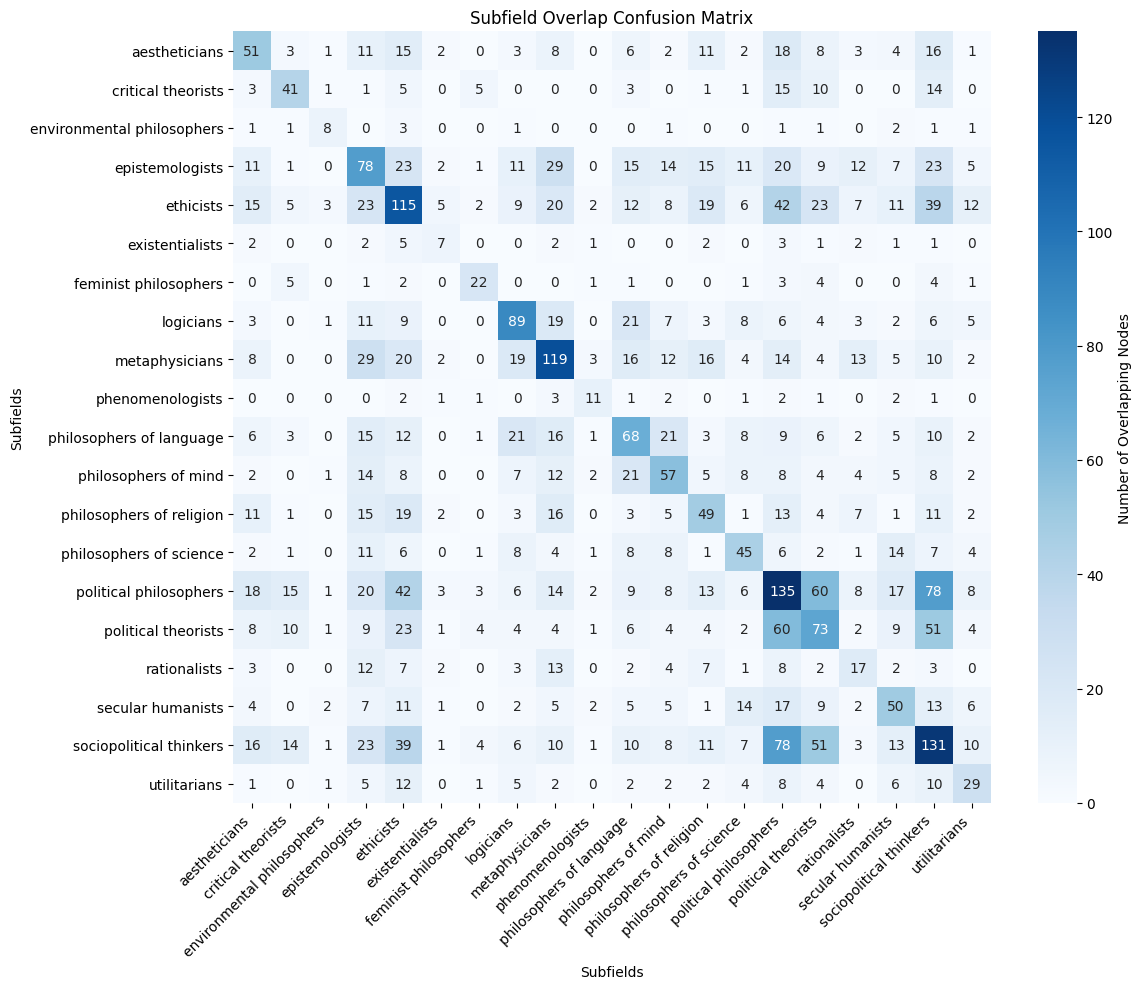

In [4]:
# Step 1: Extract subfields for all nodes
nodes_subfields = [data['subfields'] for _, data in S_subfields.nodes(data=True)]

# Step 2: Get unique subfields
all_subfields = set(subfield for sublist in nodes_subfields for subfield in sublist)
subfield_list = sorted(all_subfields)

# Step 3: Initialize a confusion matrix
n = len(subfield_list)
confusion_matrix = np.zeros((n, n), dtype=int)
subfield_to_index = {subfield: idx for idx, subfield in enumerate(subfield_list)}

# Step 4: Count shared nodes between subfields
for subfields in nodes_subfields:
    for i in range(len(subfields)):
        for j in range(len(subfields)):
            row = subfield_to_index[subfields[i]]
            col = subfield_to_index[subfields[j]]
            confusion_matrix[row, col] += 1

# Step 5: Create a DataFrame for the confusion matrix
confusion_df = pd.DataFrame(confusion_matrix, index=subfield_list, columns=subfield_list)

# Step 6: Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Number of Overlapping Nodes'})
plt.title("Subfield Overlap Confusion Matrix")
plt.xlabel("Subfields")
plt.ylabel("Subfields")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# plt.show()

# 3. Assign only one subfield to maximize modularity

In [5]:
# Prepare for modularity optimization
initial_subfields = {node: data['subfields'] for node, data in S_subfields.nodes(data=True)}

# Run greedy optimization
optimized_partition = greedy_modularity_optimization(S_subfields, initial_subfields, random_seed=42)
modularity = calculate_modularity(S_subfields, optimized_partition)
print("Modularity of the partition:", modularity)
print("Optimized partition:", optimized_partition)

# Check unassigned subfields
unassigned_subfields = find_unassigned_subfields(initial_subfields, optimized_partition)
print("Unassigned subfields:", unassigned_subfields)

# Louvain modularity
print("Louvain modularity:", get_louvain_modularity(S_subfields, optimized_partition))

# Community sizes
community_sizes = Counter(optimized_partition.values())
print("Community sizes:", community_sizes)
total_nodes = sum(community_sizes.values())
print("Total nodes:", total_nodes)

# Filter communities (retain those with >= 5 nodes)
filtered_partition = {node: community for node, community in optimized_partition.items() if community_sizes[community] >= 5}
print("Filtered partition size:", len(filtered_partition))

Modularity of the partition: 0.21717656469939634
Optimized partition: {'Ramon_Llull': 'logicians', 'Galileo_Galilei': 'philosophers of science', 'Sam_Harris': 'ethicists', 'Jacques_Rancière': 'sociopolitical thinkers', 'Bertrand_Russell': 'logicians', 'Mikhail_Bakunin': 'political theorists', 'Pythagoras': 'metaphysicians', 'Parmenides': 'metaphysicians', 'Jean_Gerson': 'political philosophers', 'Meister_Eckhart': 'metaphysicians', 'James_Harrington_(author)': 'political philosophers', 'Louis_Lavelle': 'ethicists', 'Shadworth_Hodgson': 'metaphysicians', 'John_Gray_(philosopher)': 'political philosophers', 'Ayn_Rand': 'sociopolitical thinkers', 'Samuel_ibn_Tibbon': 'philosophers of religion', 'Thomas_Aquinas': 'metaphysicians', 'Arthur_Schopenhauer': 'ethicists', 'Henri_Lefebvre': 'sociopolitical thinkers', 'Blaise_Pascal': 'ethicists', 'Carl_Gustav_Hempel': 'philosophers of science', 'Michael_Hardt': 'political philosophers', 'Giles_of_Rome': 'metaphysicians', 'Hartry_Field': 'logician

# TF-IDF on sunfield documents

In [6]:
# Extract philosopher names
philosopher_names = set()
for filename in os.listdir(DOWNLOADS_DIR):
    if filename.endswith(".txt"):
        philosopher = filename.replace(".txt", "").replace("_", " ").lower() 
        philosopher_names.update(philosopher.split())

# Additional exclusions
# additional_exclusions = {
#     'bc', 'ad', 'etc', 'philosophy', 'philosophical', 'thought', 'life', 'human',
#     'idea', 'wrote', 'first', 'would', 'also', 'one', 'two', 'three', 'four',
#     'ancient', 'medieval', 'modern', 'english', 'french', 'german'
# }
additional_exclusions = {
    'bc', 'ad', 'etc', 'philosophy', 'philosophical', 'wrote', 'first', 'would', 'also', 'one', 'two', 'three', 'four',
    'ancient', 'medieval', 'modern', 'english', 'french', 'german'
}
excluded_words = philosopher_names.union(additional_exclusions)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def compile_and_clean_all_subfields(partition, text_dir):
    subfield_texts = {}
    for subfield in set(partition.values()):
        compiled_text = ""
        philosophers = [node for node, sf in partition.items() if sf == subfield]
        for philosopher in philosophers:
            filename = os.path.join(text_dir, f"{philosopher}.txt")
            if os.path.exists(filename):
                with open(filename, "r", encoding="utf-8") as file:
                    text = file.read()
                    compiled_text += text + "\n"
            else:
                print(f"Warning: File not found for philosopher {philosopher}")
        subfield_texts[subfield] = clean_wikipedia_text(compiled_text)
    return subfield_texts

# Compile texts
subfield_texts = compile_and_clean_all_subfields(filtered_partition, DOWNLOADS_DIR)
print(f"Compiled and cleaned text for {len(subfield_texts)} subfields.")

# Process texts
word_counts_by_subfield = {}
for subfield, text in subfield_texts.items():
    word_counts_by_subfield[subfield] = process_text(text, stop_words, lemmatizer, excluded_words)

for subfield, word_counts in word_counts_by_subfield.items():
    print(f"Word counts for subfield {subfield}: {len(word_counts)}")

# Compute TF-IDF
tf_idf_scores = compute_tf_idf(word_counts_by_subfield)
for subfield, scores in tf_idf_scores.items():
    top_terms = sorted(scores, key=scores.get, reverse=True)[:5]
    print(f"Top terms for subfield {subfield}: {', '.join(top_terms)}")


Compiled and cleaned text for 17 subfields.
Word counts for subfield sociopolitical thinkers: 18538
Word counts for subfield secular humanists: 5181
Word counts for subfield political philosophers: 21061
Word counts for subfield feminist philosophers: 5612
Word counts for subfield ethicists: 16639
Word counts for subfield philosophers of science: 9290
Word counts for subfield metaphysicians: 17207
Word counts for subfield philosophers of mind: 5656
Word counts for subfield critical theorists: 8140
Word counts for subfield philosophers of language: 8049
Word counts for subfield phenomenologists: 5313
Word counts for subfield epistemologists: 9658
Word counts for subfield utilitarians: 4757
Word counts for subfield aestheticians: 9432
Word counts for subfield logicians: 12998
Word counts for subfield political theorists: 11498
Word counts for subfield philosophers of religion: 9308
Top terms for subfield sociopolitical thinkers: kmt, hunan, confucian, dynasty, rytmann
Top terms for subfi

# 5. Cosine similarity of embeddings

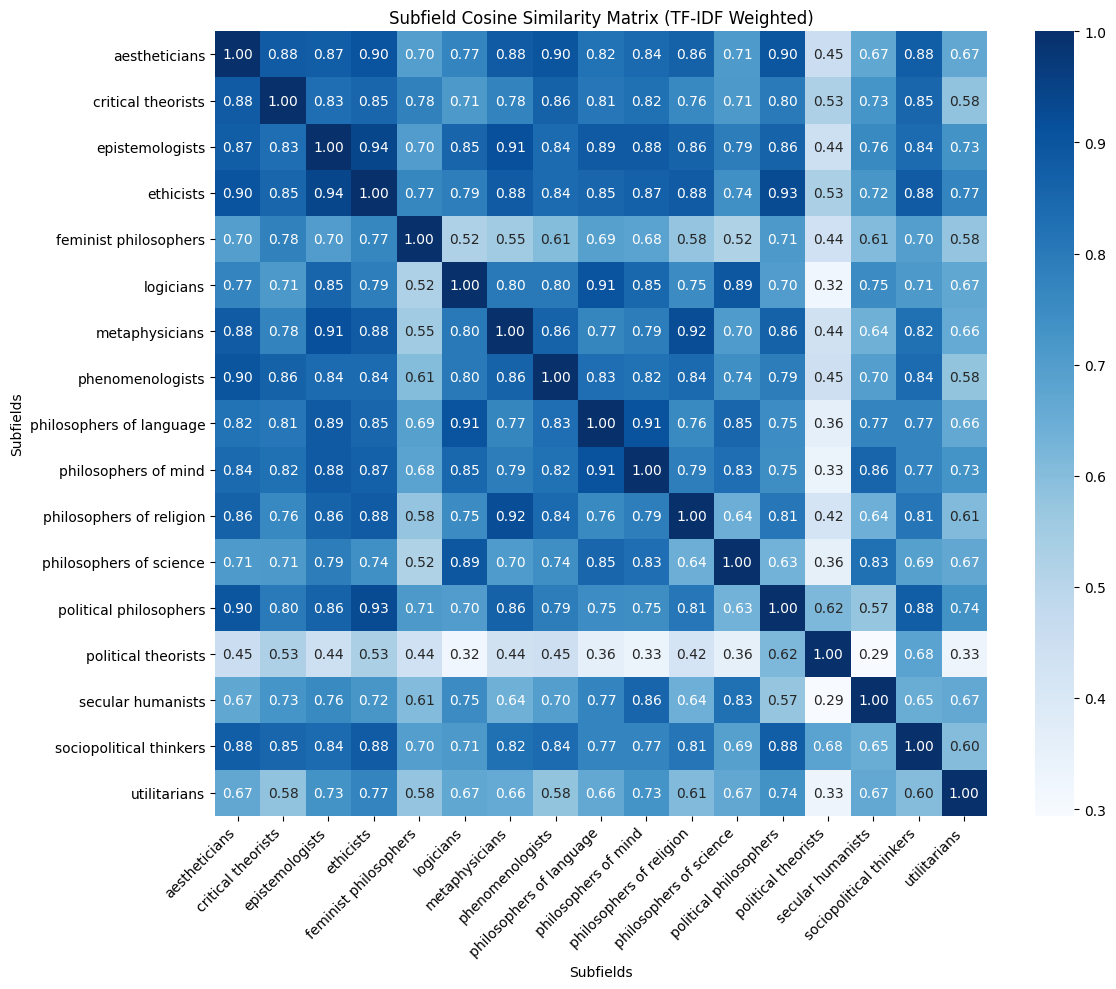

In [7]:
# Load embeddings
embeddings = load_glove_embeddings(glove_file)

# Compute embeddings
subfield_embeddings = compute_tf_idf_weighted_embeddings(tf_idf_scores, embeddings)
subfields = sorted(subfield_embeddings.keys())
embeddings_matrix = np.array([subfield_embeddings[sf] for sf in subfields])
similarity_matrix = cosine_similarity(embeddings_matrix)

# Plot similarity matrix
plot_confusion_matrix(subfields, similarity_matrix)


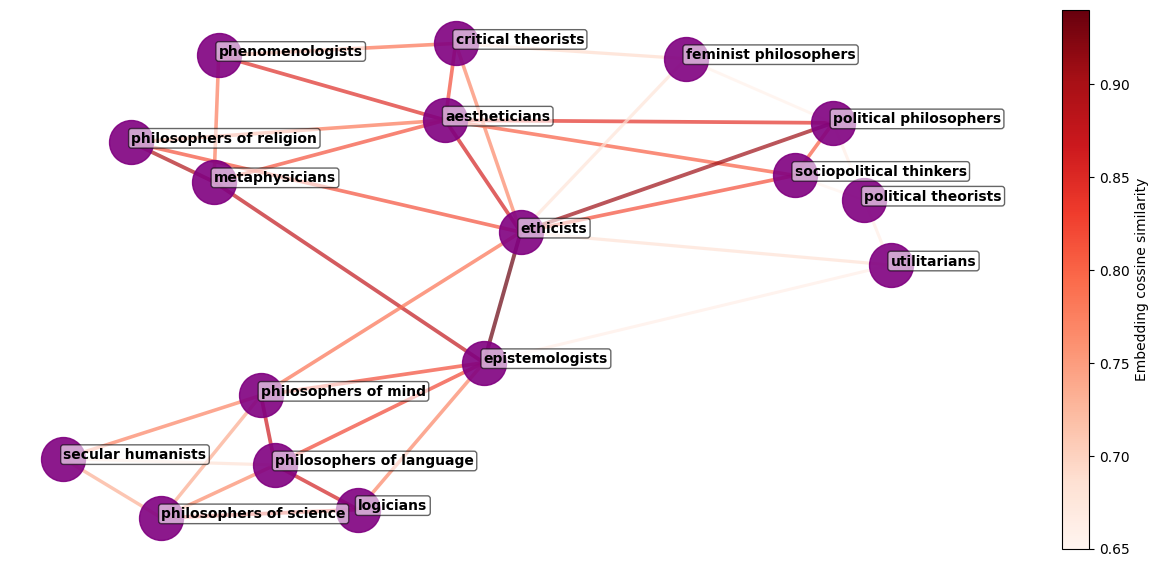

In [8]:
threshold = 0.65
G = create_similarity_graph(subfields, similarity_matrix, threshold)
top_n = 3
filtered_G = filter_top_n_edges(G, top_n)
visualize_forceatlas2_graph(filtered_G,  threshold, gamma=2.5)
